In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('muted')

### Load/prep data

In [2]:
eth_price_raw = pd.read_csv('ethereum_price.csv')

In [3]:
# set df to manipulate
eth_price = eth_price_raw[['Date', 'Close']].copy()

# convert date to datetime
eth_price['Date'] = pd.to_datetime(eth_price['Date'], format='%b %d, %Y')
eth_price.sort_values('Date', inplace=True)
eth_price.reset_index(drop=True, inplace=True)

print(eth_price.shape)
print('number of nulls: {}'.format(eth_price.isnull().any().sum()))
eth_price.head()

(929, 2)
number of nulls: 0


,Date,Close
0,2015-08-07,2.770000
1,2015-08-08,0.753325
2,2015-08-09,0.701897
3,2015-08-10,0.708448
4,2015-08-11,1.070000


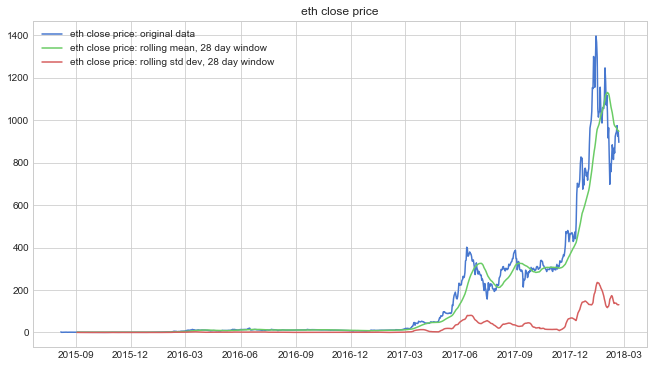

adf: -1.0177344392596426
pval: 0.7467412431946142
critical vals {'1%': -3.4375803238413085, '5%': -2.8647318597670877, '10%': -2.568469555703587}


In [4]:
plt.figure(figsize=(11,6))
plt.plot(
    eth_price['Date'],
    eth_price['Close'],
    label='eth close price: original data'
)
plt.plot(
    eth_price['Date'],
    eth_price['Close'].rolling(28).mean(),
    label='eth close price: rolling mean, 28 day window'
)
plt.plot(
    eth_price['Date'],
    eth_price['Close'].rolling(28).std(),
    label='eth close price: rolling std dev, 28 day window'
)
plt.title('eth close price')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price['Close'])[0],
    adfuller(eth_price['Close'])[1],
    adfuller(eth_price['Close'])[4]))

In [5]:
# try a couple methods to get stationary dataset
eth_price['diff_1'] = eth_price.Close - eth_price.Close.shift()
eth_price['log_return'] = (np.log(eth_price.Close) 
                           - np.log(eth_price.Close.shift(1)))
# handle Nans from differencing
eth_price = eth_price[2:]
eth_price.head()

,Date,Close,diff_1,log_return
2,2015-08-09,0.701897,-0.051428,-0.070710
3,2015-08-10,0.708448,0.006551,0.009290
4,2015-08-11,1.070000,0.361552,0.412337
5,2015-08-12,1.220000,0.150000,0.131192
6,2015-08-13,1.830000,0.610000,0.405465


In [6]:
eth_price.shape

(927, 4)

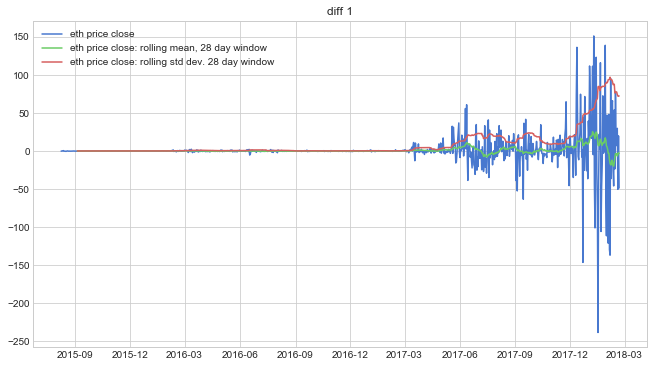

adf: -4.190611873493565
pval: 0.0006834299211675219
critical vals {'1%': -3.437596348122793, '5%': -2.86473892523805, '10%': -2.5684733191905007}


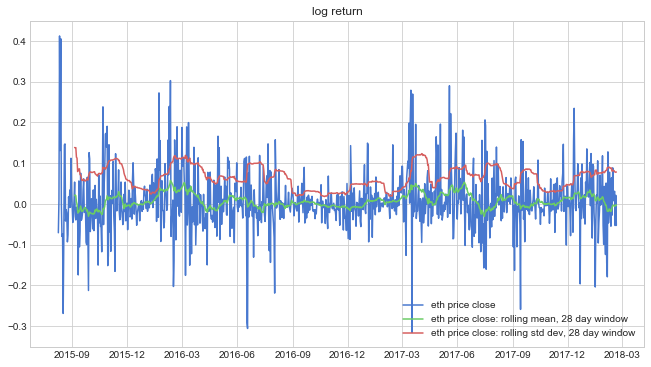

adf: -16.386151109164704
pval: 2.7218593944952824e-29
critical vals {'1%': -3.437446926086526, '5%': -2.8646730402041443, '10%': -2.568438225155076}


In [7]:
# 1st order difference plot
plt.figure(figsize=(11,6))
plt.plot(
    eth_price['Date'],
    eth_price['diff_1'],
    label='eth price close'
)
plt.plot(
    eth_price['Date'],
    eth_price['diff_1'].rolling(28).mean(),
    label='eth price close: rolling mean, 28 day window'
)
plt.plot(
    eth_price['Date'],
    eth_price['diff_1'].rolling(28).std(),
    label='eth price close: rolling std dev. 28 day window'
)
plt.title('diff 1')
plt.legend(loc='upper left')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price['diff_1'])[0],
    adfuller(eth_price['diff_1'])[1],
    adfuller(eth_price['diff_1'])[4]))

# log return plot
plt.figure(figsize=(11,6))
plt.plot(
    eth_price['Date'],
    eth_price['log_return'],
    label='eth price close'
)
plt.plot(
    eth_price['Date'],
    eth_price['log_return'].rolling(28).mean(),
    label='eth price close: rolling mean, 28 day window'
)
plt.plot(
    eth_price['Date'],
    eth_price['log_return'].rolling(28).std(),
    label='eth price close: rolling std dev, 28 day window'
)
plt.title('log return')
plt.legend(loc='lower right')
plt.show()

print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(eth_price['log_return'])[0],
    adfuller(eth_price['log_return'])[1],
    adfuller(eth_price['log_return'])[4]))

### Autocorrelation Functions (ACF/PACF)
- Using log return data as it had better adf results

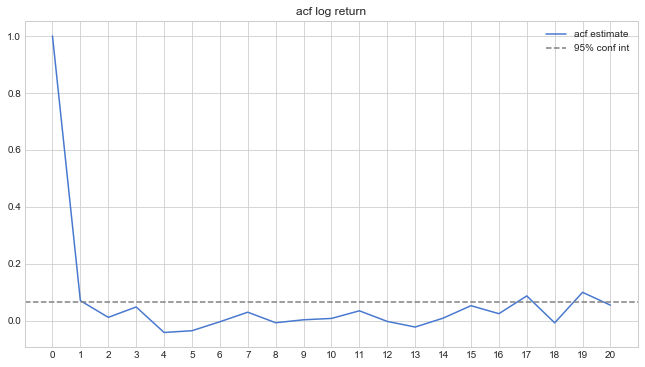

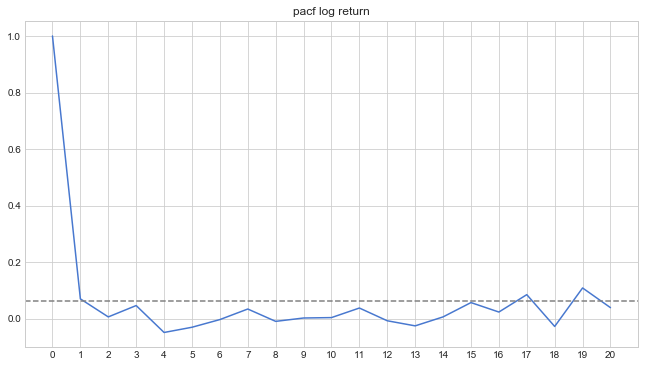

In [8]:
log_return_acf = acf(eth_price.log_return, nlags=20)
log_return_pacf = pacf(eth_price.log_return, nlags=20, method='ols')

plt.figure(figsize=(11,6))
plt.plot(log_return_acf, label='acf estimate')
plt.axhline(y=1.96/np.sqrt(len(eth_price.log_return)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('acf log return')
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(log_return_pacf, label='pacf estimate')
plt.axhline(y=1.96/np.sqrt(len(eth_price.log_return)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('pacf log return')
plt.show()

ARIMA(p,d,q) for log_return
- $p=1$
- $q=1$

                              ARMA Model Results                              
Dep. Variable:             log_return   No. Observations:                  927
Model:                     ARMA(1, 0)   Log Likelihood                1110.520
Method:                       css-mle   S.D. of innovations              0.073
Date:                Thu, 06 Sep 2018   AIC                          -2215.040
Time:                        20:10:13   BIC                          -2200.544
Sample:                             0   HQIC                         -2209.510
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0076      0.003      2.956      0.003       0.003       0.013
ar.L1.log_return     0.0705      0.033      2.152      0.032       0.006       0.135
                            

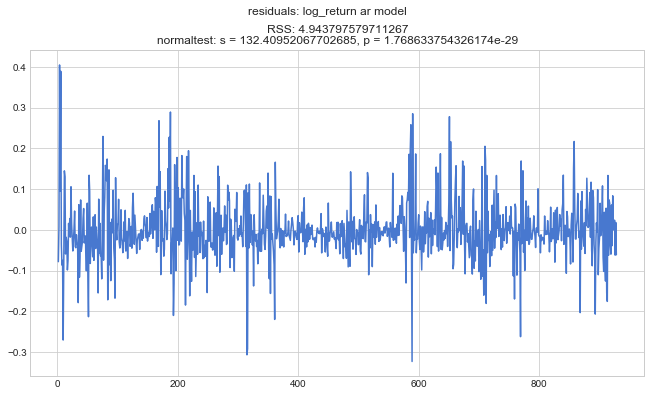

                              ARMA Model Results                              
Dep. Variable:             log_return   No. Observations:                  927
Model:                     ARMA(0, 1)   Log Likelihood                1110.494
Method:                       css-mle   S.D. of innovations              0.073
Date:                Thu, 06 Sep 2018   AIC                          -2214.987
Time:                        20:10:13   BIC                          -2200.491
Sample:                             0   HQIC                         -2209.458
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0076      0.003      2.972      0.003       0.003       0.013
ma.L1.log_return     0.0700      0.033      2.136      0.033       0.006       0.134
                            

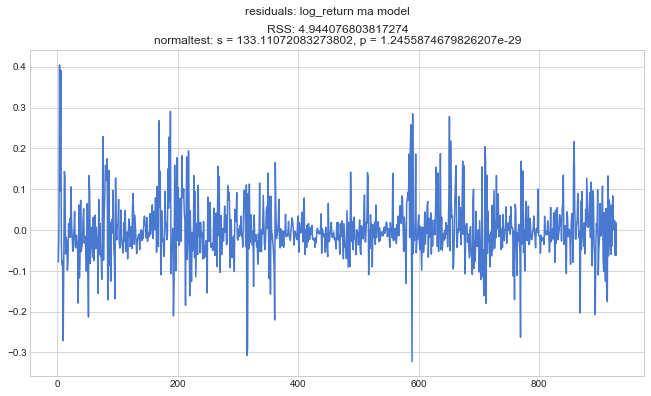

                              ARMA Model Results                              
Dep. Variable:             log_return   No. Observations:                  927
Model:                     ARMA(1, 1)   Log Likelihood                1110.612
Method:                       css-mle   S.D. of innovations              0.073
Date:                Thu, 06 Sep 2018   AIC                          -2213.225
Time:                        20:10:13   BIC                          -2193.897
Sample:                             0   HQIC                         -2205.852
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0076      0.003      2.892      0.004       0.002       0.013
ar.L1.log_return     0.3149      0.407      0.774      0.439      -0.482       1.112
ma.L1.log_return    -0.2465 

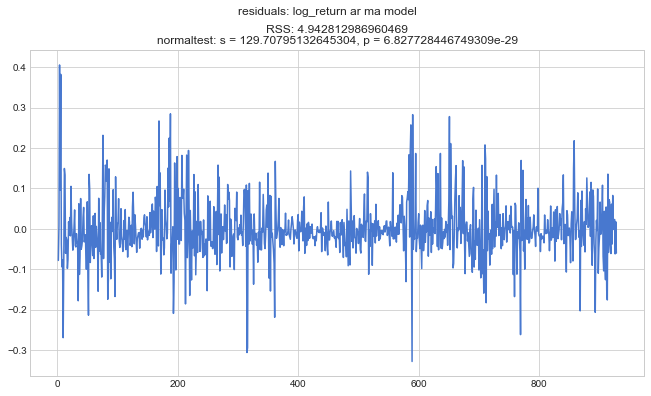

quick comparison:

ar(1) model:
AIC: -2215.039640732255, RSS: 4.943798

ma(1) model:
AIC: -2214.987250652087, RSS:4.944077

combined model:
AIC: -2213.2245695807997, RSS:4.942813


In [11]:
ar_model = ARIMA(eth_price.log_return, order=(1,0,0)).fit()
ma_model = ARIMA(eth_price.log_return, order=(0,0,1)).fit()
ar_ma_model = ARIMA(eth_price.log_return, order=(1,0,1)).fit()

print(ar_model.summary())
s_ar, p_ar = normaltest(ar_model.resid)
rss_ar = sum((ar_model.fittedvalues-eth_price.log_return) ** 2)
plt.figure(figsize=(11,6))
plt.suptitle('residuals: log_return ar model')
plt.plot(ar_model.resid)
plt.title('RSS: {0}\nnormaltest: s = {1}, p = {2}'
          .format(rss_ar, s_ar, p_ar))
plt.show()

print(ma_model.summary())
s_ma, p_ma = normaltest(ma_model.resid)
rss_ma = sum((ma_model.fittedvalues-eth_price.log_return) ** 2)
plt.figure(figsize=(11,6))
plt.suptitle('residuals: log_return ma model')
plt.plot(ma_model.resid)
plt.title('RSS: {0}\nnormaltest: s = {1}, p = {2}'
          .format(rss_ma, s_ma, p_ma))
plt.show()

print(ar_ma_model.summary())
s_ar_ma, p_ar_ma = normaltest(ar_ma_model.resid)
rss_ar_ma = sum((ar_ma_model.fittedvalues-eth_price.log_return) ** 2)
plt.figure(figsize=(11,6))
plt.suptitle('residuals: log_return ar ma model')
plt.plot(ar_ma_model.resid)
plt.title('RSS: {0}\nnormaltest: s = {1}, p = {2}'
          .format(rss_ar_ma, s_ar_ma, p_ar_ma))
plt.show()

print('quick comparison:')
print('\nar(1) model:\nAIC: {0}, RSS: {1:.6f}'.format(ar_model.aic, rss_ar))
print('\nma(1) model:\nAIC: {0}, RSS:{1:.6f}'.format(ma_model.aic, rss_ma))
print('\ncombined model:\nAIC: {0}, RSS:{1:.6f}'.format(ar_ma_model.aic, rss_ar_ma))

### Forecasting

In [70]:
from sklearn.metrics import mean_squared_error

# 30 day window
window = 30
X = pd.DataFrame()
X['date'] = eth_price['Date'].copy()
#X['log_return_actual'] = eth_price['log_return']
X['log_return_forecast'] = eth_price['log_return'][:window]
X.reset_index(drop=True, inplace=True)
print(X.shape)

(927, 2)


In [71]:
for n in range(len(X)):
    start = n
    stop = window + n
    if stop <= len(X):
        data = X[start:stop]
        model = ARIMA(data.log_return_forecast, order=(1,0,0)).fit()
        X.log_return_forecast[stop] = model.forecast()[0]
    else:
        break

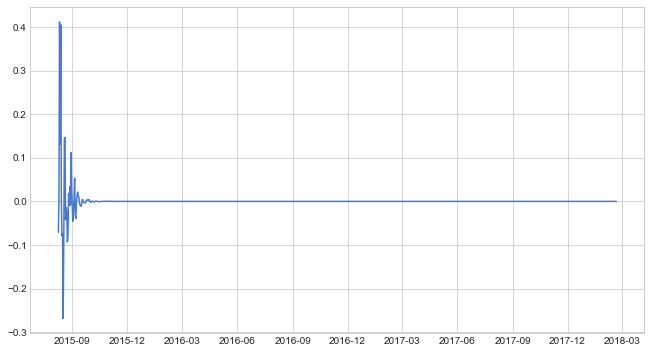

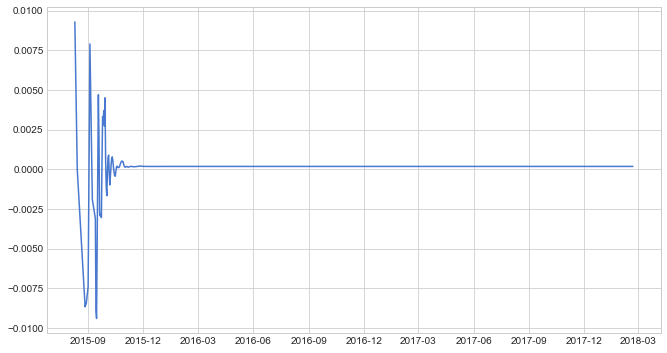

In [90]:
plt.figure(figsize=(11,6))
plt.plot(X.date[:len(X)], X.log_return_forecast[:len(X)])
plt.show()

X2 = X.loc[X['log_return_forecast'] <= 0.01]
X2 = X2.loc[X2['log_return_forecast'] >= -0.01]
X2.reset_index(inplace=True, drop=True)

plt.figure(figsize=(11,6))
plt.plot(X2.date[:len(X2)], X2.log_return_forecast[:len(X2)])
plt.show()

### Exogenous variables
- **[CBOE Volatility Index (VIX)](https://en.wikipedia.org/wiki/VIX)**: measure of stock market's expectation of volatility implied by S&P 500 index options, aka 'fear index'
     - [Data Source](http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/vix-historical-data)
- **[US Dollar Index (DXY)](https://en.wikipedia.org/wiki/U.S._Dollar_Index)**: measure of value of USD relative to a basket of foreign currencies
    - [Data Source](https://quotes.wsj.com/index/DXY/historical-prices)
- **[Federal Funds Rate (EFFR)](https://en.wikipedia.org/wiki/Federal_funds_rate)**: the interest rate at which depository institutions (banks and credit unions) lend reserve balances to other depository institutions overnight, on an uncollateralized basis 
    - [Data Source](https://fred.stlouisfed.org/series/EFFR)

In [ ]:
# date range
print('{}\n{}'.format(eth_price.Date.head(1),
                      eth_price.Date.tail(1)))
print(len(eth_price))

In [ ]:
vix_raw = pd.read_csv('vixcurrent.csv', header=1)
print(vix_raw.info())

In [ ]:
vix_raw[:1]

In [ ]:
vix_close = vix_raw[['Date', 'VIX Close']].copy()
vix_close['Date'] = pd.to_datetime(vix_close['Date'], format='%m/%d/%Y')
vix_close.sort_values('Date', inplace=True)
vix_close.reset_index(drop=True, inplace=True)
vix_close.head()

In [ ]:
vix_close = vix_close.loc[(vix_close['Date'] >= '2015-08-07')
                          & (vix_close['Date'] <= '2018-02-20')]

In [ ]:
vix_close.reset_index(drop=True, inplace=True)

In [ ]:
vix_close.tail()

In [ ]:
print(vix_close.shape)

In [ ]:
eth_exog = eth_price.merge(vix_close, how='outer', on='Date')
eth_exog.columns = ['date', 'eth_close', 'vix_close']
eth_exog.head(10)

In [ ]:
dxy_raw = pd.read_csv('dxy_historical.csv')
dxy_raw[:1]

In [ ]:
dxy_raw.info()

In [ ]:
dxy_close = dxy_raw[['Date', ' Close']].copy()
dxy_close['Date'] = pd.to_datetime(dxy_close['Date'], format='%x')
dxy_close.sort_values('Date', inplace=True)
dxy_close.reset_index(drop=True, inplace=True)
dxy_close.columns = ['date', 'close']
dxy_close.head()

In [ ]:
print(dxy_close.shape)

In [ ]:
eth_exog = eth_exog.merge(dxy_close, how='outer', on='date')
eth_exog.columns = ['date', 'eth_close', 'vix_close', 'dxy_close']
eth_exog.head(10)

In [ ]:
effr_raw = pd.read_csv('EFFR.csv')
effr_raw.head()

In [ ]:
effr = effr_raw.copy()
effr.columns = ['date', 'effr']
effr['date'] = pd.to_datetime(effr['date'], format='%Y-%m-%d')
effr.sort_values('date', inplace=True)
effr = effr.loc[(effr['date'] >= '2015-08-07') & (effr['date'] <= '2018-02-20')]
effr.reset_index(drop=True, inplace=True)
effr.head()

In [ ]:
effr.info()

In [ ]:
effr['effr'].value_counts().sort_values(ascending=True)

In [ ]:
print(effr.loc[effr['effr'] == '.'])
print('\n{}'.format(len(effr.loc[effr['effr'] == '.'])))

In [ ]:
eth_exog = eth_exog.merge(effr, how='outer', on='date')

In [ ]:
eth_exog.head()

In [ ]:
print(eth_exog.loc[eth_exog['effr'] == '.'])
print('\n{}'.format(len(eth_exog.loc[eth_exog['effr'] == '.'])))